<img src="http://www.ceic.org.ar/spanish/img/siisa-logo.jpg" align='right'>

# Opera  y cumple.
Autor:Dr. López Elias Daniel

## Descripción de la problemática.

### Motivación:

A fin de caracterizar las personas física con el fin de otorgales prestamos/beneficios se relevan algunas variables de interés. En muchas ocasiones una persona física no se cuenta con historial y/o comportamiento crediticio al momento de la consulta, por ende desarrollar variables explicativas para caracterizar este segmento de la población es de vital importancia. Para ello se determinaron algunos de los criterios para estimar si una persona física "Opera y cumple" basado en el número de consultas realizadas por entidades sujetas a la base SIISA en un dado periodo de tiempo. Esta hipótesis de trabajo se denominó "hipotesis Sokal" y esta implementada en el motor bajo el sp denominado "MINISIISA.dbo.sub_operaYcumple".
   
## Introducción: 

El éxito de la variable OyC radica en la naturaleza misma de la consulta. Las consultas no son en vano sino que responden a una necesidad/deseo  por el cliente por adquirir un prestamo/credito, por lo que la población consultada esta sesgada hacia la conversión. 
   
   
### Materiales y métodos.
Tomamos todas las consultas que se efectuaron entre el mes 05 al 07 de 2018 (Figura) evaluando si dichas consultas luego del 30/07/2018 operaban y cumplían con dicha entidad, denotado como una situación 1 en BCRA. Se descartaron a todas las situaciones mayores a 1.

A partir de dicha consulta se constituyeron dos grupos: 
- El primer Grupo NOOyC son aquellos cuiles que fueron consultados, pero dicha consulta no terminó en una operacion con dicha entidad. 
- El segundo grupo fue constituido por aquellos que sí fueron consultados y operaron a posteriori con la entidad. 

La consulta SQL que generó el subset de datos esta guardado en el archivo 'OyC20191002.sql'



<img src="OyC.png" width="400">

## Resultados:

### Explicación de variables:
- **Score y variables derivadas**: Se relevaron para cada cuil todas las variables del score y además todas las variables derivadas luego de ejecutar 'magia negra'.

- **Variables de consultas**: Para cada par (cuil, entidad) se devuelve el número de consultas efectuadas por la entidad, entre la fecha de consulta y 5 años para atrás asi como tiempo interconsulta max, min y promedio. Si la consulta fue efectuada con score tambien se relevaron metricas como score promedio, min y max de cada par cuil, entidad. Cuando el score no fue relevado ponemos -1.

- **Clasificacion por 'tipo de entidad'**: Se clasificó cada entidad como entidad retail o credito dirigido (R), como entidad emisora de tarjeta (T), entidad financiera (F) o bancos (B). Dicha 'clasificacion' esta almacenada en [feliTest].[dbo].[OyC_entidades_clasificacion]
- **Variable Objetivo**: La variable objetivo se llama 'OyC' y es de tipo binaria. NOOyC es 0 y OyC es 1.

In [1]:
# Importo las librerias a utilizar.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from siisa import * 

In [2]:
# Importo los datos creados como se explico anteriormente.
df=pd.read_csv('opera_y_cumple2019-10-14.csv',delimiter=';')
df2=pd.read_csv('classification.csv',delimiter=',')

In [3]:
df=pd.merge(df,df2,how='left',left_on='entidad',right_on='IdEntidad')

In [4]:
# saco las filas que tengan cuil nulo.
df.dropna(subset=['cuil'],inplace=True)
# convierto a entero el cuil 
df['cuil']=df.cuil.astype('int64')

In [5]:
df.shape

(321634, 151)

In [6]:
# Genero las variables dummies de la clasificacion. 
dumm= pd.get_dummies(df['classification'],drop_first=True,prefix='class')
# Genero las dummies del sexo. 
sex = pd.get_dummies(df['SEXO'],drop_first=True,prefix='sex')
# borro las columnas IdEntidad, Razon Social,  classificacion  y sexo.
del df['IdEntidad']
del df['RazonSocial']
del df['classification']
del df['SEXO']
# Uno los dataframes de dummies al df original. 
df=pd.concat([pd.concat([df,dumm],axis=1),sex],axis=1)

In [75]:
# imputo por la media de cada scorecard en el ingreso.
df['ingresoFilled']=df.groupby('scorecard')['ingreso'].transform(lambda x: x.fillna(x.mean()))

In [104]:
df.groupby('scorecard')['ingreso'].agg({'suma' : np.sum,'media' : np.mean})

C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,suma,media
scorecard,,
1.0,724753.0,24.672443
3.0,1013452.0,28.466154
4.0,2211913.0,26.315694
5.0,564763.0,29.011301
6.0,374248.0,17.937500
7.0,16788.0,21.116981


In [7]:
df.head()

,entidad,nconsultas,tiempo_interconsulta_avg,tiempo_interconsulta_max,tiempo_interconsulta_min,score_enconsulta_avg,score_enconsulta_max,score_enconsulta_min,usa_score,OyC,...,bcraNoFinanciera,bcraBanco,score,fechaActual,ingreso,class_F,class_R,class_T,sex_1.0,sex_2.0
0,754,4,8,21,2,-1,-1,-1,0,1,...,1.0,1.0,518.0,2019-10-05 15:42:40.737,5.0,0,1,0,0,1
1,200,1,99,99,99,851,851,851,1,1,...,1.0,1.0,518.0,2019-10-05 15:42:40.737,5.0,0,0,0,0,1
2,625,3,5,8,2,884,884,884,1,1,...,1.0,1.0,518.0,2019-10-05 15:42:40.737,5.0,0,0,1,0,1
3,18,2,4,4,4,-1,-1,-1,0,1,...,1.0,1.0,518.0,2019-10-05 15:42:40.737,5.0,0,0,1,0,1
4,355,1,99,99,99,812,812,812,1,1,...,1.0,1.0,518.0,2019-10-05 15:42:40.737,5.0,0,1,0,0,1


In [8]:
# Relevar la proporcion de OyC en funcion del numero de consultas.
porcentajes_list=[]
for cons in (1,2,3,4,5):
    vc=df[df['nconsultas'] == cons]['OyC'].value_counts(normalize=True)*100
    oyc=vc[vc.index==1].values[0]
    NOoyc=vc[vc.index==0].values[0]
    porcentajes_list.append( {'OyC':oyc,'noOyC':NOoyc})

In [9]:
consultas=pd.DataFrame(porcentajes_list).rename(index={0: "1 Consultas", 1: "2 Consultas", 2: "3 Consultas",3: "4 Consultas",4: "5 Consultas"})

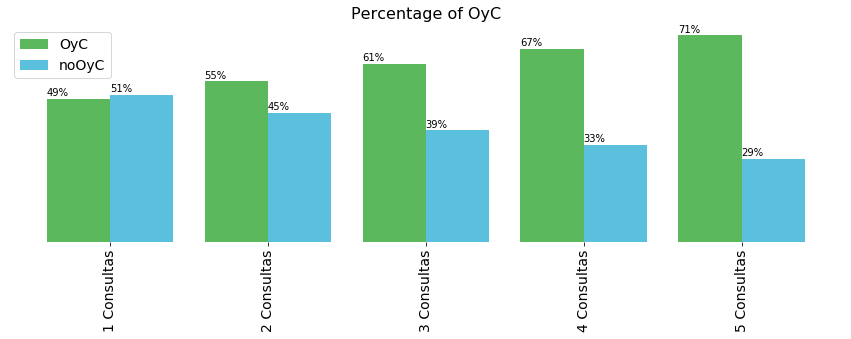

In [10]:
colors_list = ['#5cb85c','#5bc0de','#d9534f']

# Change this line to plot percentages instead of absolute values
ax = (consultas.div(consultas.sum(1), axis=0)).plot(kind='bar',figsize=(15,4),width = 0.8,color = colors_list,edgecolor=None)
plt.legend(labels=consultas.columns,fontsize= 14)
plt.title("Percentage of OyC",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (x, y + height + 0.01))

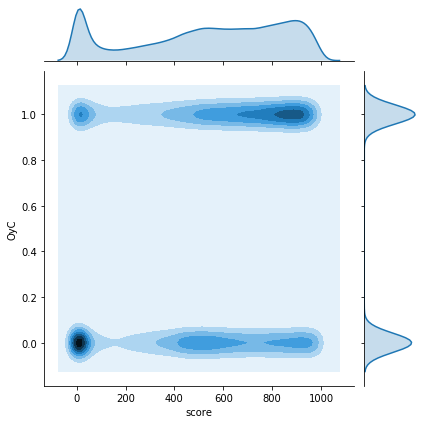

In [12]:
# Distribucion de score y OyC
sns.jointplot(x=df.score, y=df.OyC, kind='kde');

Se puede observar que la distribución de scores sobre los OyC esta acompañada de un buen score, aunque hay buenos scores que no OyC por lo que entendemos que hay 'desistidos'.

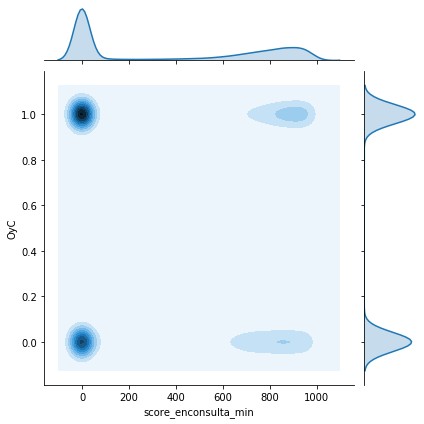

In [13]:
sns.jointplot(x=df.score_enconsulta_min, y=df.OyC, kind='kde')

In [14]:
# Dataset Balancedo.
df.OyC.value_counts(normalize=True)*100

1    51.778108
0    48.221892
Name: OyC, dtype: float64

**Conclusión Parcial**: Partimos de un Dataset balanceado de manera artificial, sin embargo se observa que conforme se aumenta el número de consultas, la proporción de OyC aumenta. Además los gráficos de score y score en consulta, vemos el mismo patrón que el OyC esta en general acompañado de un buen score al momento de la consulta. 

In [15]:
X_total=df.copy()
X_total.mesesBancarizacion.fillna(999,inplace=True)
X_total.score.fillna(-1,inplace=True)
y_total=df['OyC']
del X_total['OyC']
del X_total['fecha']
del X_total['fechaActual']
del X_total['entidad']

In [16]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, yt_train, yt_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

In [17]:
from catboost import CatBoostClassifier

model_cat_total = CatBoostClassifier(
    custom_loss=['Precision'] , #cat_features=cat_names,
    random_seed=42 
)
model_cat_total.fit(Xt_train, yt_train,             
    eval_set=(Xt_test, yt_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.139749
0:	learn: 0.6550752	test: 0.6545394	best: 0.6545394 (0)	total: 443ms	remaining: 7m 22s
1:	learn: 0.6274905	test: 0.6263779	best: 0.6263779 (1)	total: 736ms	remaining: 6m 7s
2:	learn: 0.6070839	test: 0.6055237	best: 0.6055237 (2)	total: 1.12s	remaining: 6m 11s
3:	learn: 0.5915094	test: 0.5895432	best: 0.5895432 (3)	total: 1.42s	remaining: 5m 54s
4:	learn: 0.5795637	test: 0.5772525	best: 0.5772525 (4)	total: 1.82s	remaining: 6m 3s
5:	learn: 0.5703572	test: 0.5676589	best: 0.5676589 (5)	total: 2.25s	remaining: 6m 13s
6:	learn: 0.5637500	test: 0.5607885	best: 0.5607885 (6)	total: 2.57s	remaining: 6m 4s
7:	learn: 0.5573238	test: 0.5542550	best: 0.5542550 (7)	total: 2.88s	remaining: 5m 57s
8:	learn: 0.5524708	test: 0.5493331	best: 0.5493331 (8)	total: 3.17s	remaining: 5m 49s
9:	learn: 0.5485022	test: 0.5454028	best: 0.5454028 (9)	total: 3.43s	remaining: 5m 39s
10:	learn: 0.5454761	test: 0.5422861	best: 0.5422861 (10)	total: 3.74s	remaining: 5m 36s
11:	learn: 0.5

93:	learn: 0.4941848	test: 0.4930838	best: 0.4930838 (93)	total: 27.9s	remaining: 4m 28s
94:	learn: 0.4939520	test: 0.4928947	best: 0.4928947 (94)	total: 28.2s	remaining: 4m 28s
95:	learn: 0.4937697	test: 0.4927310	best: 0.4927310 (95)	total: 28.4s	remaining: 4m 27s
96:	learn: 0.4935245	test: 0.4925306	best: 0.4925306 (96)	total: 28.7s	remaining: 4m 26s
97:	learn: 0.4932958	test: 0.4923397	best: 0.4923397 (97)	total: 29s	remaining: 4m 26s
98:	learn: 0.4929974	test: 0.4920825	best: 0.4920825 (98)	total: 29.2s	remaining: 4m 26s
99:	learn: 0.4927029	test: 0.4918069	best: 0.4918069 (99)	total: 29.5s	remaining: 4m 25s
100:	learn: 0.4923675	test: 0.4915302	best: 0.4915302 (100)	total: 29.8s	remaining: 4m 24s
101:	learn: 0.4920304	test: 0.4912827	best: 0.4912827 (101)	total: 30s	remaining: 4m 24s
102:	learn: 0.4914959	test: 0.4908097	best: 0.4908097 (102)	total: 30.4s	remaining: 4m 24s
103:	learn: 0.4912104	test: 0.4905508	best: 0.4905508 (103)	total: 30.6s	remaining: 4m 23s
104:	learn: 0.490

184:	learn: 0.4721120	test: 0.4746532	best: 0.4746532 (184)	total: 52.4s	remaining: 3m 51s
185:	learn: 0.4718328	test: 0.4744077	best: 0.4744077 (185)	total: 52.7s	remaining: 3m 50s
186:	learn: 0.4716015	test: 0.4742236	best: 0.4742236 (186)	total: 52.9s	remaining: 3m 50s
187:	learn: 0.4713317	test: 0.4739840	best: 0.4739840 (187)	total: 53.2s	remaining: 3m 49s
188:	learn: 0.4711328	test: 0.4738705	best: 0.4738705 (188)	total: 53.4s	remaining: 3m 49s
189:	learn: 0.4710203	test: 0.4738250	best: 0.4738250 (189)	total: 53.7s	remaining: 3m 48s
190:	learn: 0.4708001	test: 0.4736655	best: 0.4736655 (190)	total: 54s	remaining: 3m 48s
191:	learn: 0.4705687	test: 0.4734901	best: 0.4734901 (191)	total: 54.2s	remaining: 3m 48s
192:	learn: 0.4704415	test: 0.4733784	best: 0.4733784 (192)	total: 54.5s	remaining: 3m 47s
193:	learn: 0.4702683	test: 0.4732494	best: 0.4732494 (193)	total: 54.8s	remaining: 3m 47s
194:	learn: 0.4701510	test: 0.4731515	best: 0.4731515 (194)	total: 55s	remaining: 3m 46s
195

275:	learn: 0.4568831	test: 0.4626193	best: 0.4626193 (275)	total: 1m 16s	remaining: 3m 21s
276:	learn: 0.4567036	test: 0.4624690	best: 0.4624690 (276)	total: 1m 16s	remaining: 3m 20s
277:	learn: 0.4565975	test: 0.4623852	best: 0.4623852 (277)	total: 1m 17s	remaining: 3m 20s
278:	learn: 0.4564026	test: 0.4622147	best: 0.4622147 (278)	total: 1m 17s	remaining: 3m 20s
279:	learn: 0.4562589	test: 0.4621079	best: 0.4621079 (279)	total: 1m 17s	remaining: 3m 19s
280:	learn: 0.4561066	test: 0.4619667	best: 0.4619667 (280)	total: 1m 17s	remaining: 3m 19s
281:	learn: 0.4559893	test: 0.4618765	best: 0.4618765 (281)	total: 1m 18s	remaining: 3m 19s
282:	learn: 0.4558504	test: 0.4617331	best: 0.4617331 (282)	total: 1m 18s	remaining: 3m 18s
283:	learn: 0.4557657	test: 0.4616506	best: 0.4616506 (283)	total: 1m 18s	remaining: 3m 18s
284:	learn: 0.4556059	test: 0.4615239	best: 0.4615239 (284)	total: 1m 18s	remaining: 3m 18s
285:	learn: 0.4554836	test: 0.4614331	best: 0.4614331 (285)	total: 1m 19s	remain

365:	learn: 0.4448667	test: 0.4537530	best: 0.4537530 (365)	total: 1m 41s	remaining: 2m 56s
366:	learn: 0.4447749	test: 0.4536978	best: 0.4536978 (366)	total: 1m 42s	remaining: 2m 56s
367:	learn: 0.4445536	test: 0.4535389	best: 0.4535389 (367)	total: 1m 42s	remaining: 2m 56s
368:	learn: 0.4443350	test: 0.4533615	best: 0.4533615 (368)	total: 1m 42s	remaining: 2m 55s
369:	learn: 0.4441344	test: 0.4532125	best: 0.4532125 (369)	total: 1m 43s	remaining: 2m 55s
370:	learn: 0.4439994	test: 0.4531183	best: 0.4531183 (370)	total: 1m 43s	remaining: 2m 55s
371:	learn: 0.4438704	test: 0.4530189	best: 0.4530189 (371)	total: 1m 43s	remaining: 2m 55s
372:	learn: 0.4437226	test: 0.4529047	best: 0.4529047 (372)	total: 1m 44s	remaining: 2m 54s
373:	learn: 0.4435962	test: 0.4528662	best: 0.4528662 (373)	total: 1m 44s	remaining: 2m 54s
374:	learn: 0.4434595	test: 0.4527527	best: 0.4527527 (374)	total: 1m 44s	remaining: 2m 54s
375:	learn: 0.4433564	test: 0.4526759	best: 0.4526759 (375)	total: 1m 44s	remain

455:	learn: 0.4339647	test: 0.4458937	best: 0.4458937 (455)	total: 2m 7s	remaining: 2m 31s
456:	learn: 0.4338440	test: 0.4458058	best: 0.4458058 (456)	total: 2m 7s	remaining: 2m 31s
457:	learn: 0.4337445	test: 0.4457307	best: 0.4457307 (457)	total: 2m 7s	remaining: 2m 31s
458:	learn: 0.4336170	test: 0.4456343	best: 0.4456343 (458)	total: 2m 8s	remaining: 2m 30s
459:	learn: 0.4335614	test: 0.4455890	best: 0.4455890 (459)	total: 2m 8s	remaining: 2m 30s
460:	learn: 0.4334491	test: 0.4455304	best: 0.4455304 (460)	total: 2m 8s	remaining: 2m 30s
461:	learn: 0.4333607	test: 0.4454351	best: 0.4454351 (461)	total: 2m 8s	remaining: 2m 30s
462:	learn: 0.4332749	test: 0.4453792	best: 0.4453792 (462)	total: 2m 9s	remaining: 2m 29s
463:	learn: 0.4331675	test: 0.4453005	best: 0.4453005 (463)	total: 2m 9s	remaining: 2m 29s
464:	learn: 0.4330059	test: 0.4451698	best: 0.4451698 (464)	total: 2m 9s	remaining: 2m 29s
465:	learn: 0.4329266	test: 0.4451120	best: 0.4451120 (465)	total: 2m 9s	remaining: 2m 28s

545:	learn: 0.4242353	test: 0.4384634	best: 0.4384634 (545)	total: 2m 33s	remaining: 2m 7s
546:	learn: 0.4241659	test: 0.4384053	best: 0.4384053 (546)	total: 2m 33s	remaining: 2m 7s
547:	learn: 0.4240633	test: 0.4383150	best: 0.4383150 (547)	total: 2m 33s	remaining: 2m 6s
548:	learn: 0.4239256	test: 0.4381944	best: 0.4381944 (548)	total: 2m 34s	remaining: 2m 6s
549:	learn: 0.4237675	test: 0.4380740	best: 0.4380740 (549)	total: 2m 34s	remaining: 2m 6s
550:	learn: 0.4236226	test: 0.4379621	best: 0.4379621 (550)	total: 2m 34s	remaining: 2m 5s
551:	learn: 0.4235609	test: 0.4379190	best: 0.4379190 (551)	total: 2m 34s	remaining: 2m 5s
552:	learn: 0.4234261	test: 0.4378198	best: 0.4378198 (552)	total: 2m 35s	remaining: 2m 5s
553:	learn: 0.4233254	test: 0.4377280	best: 0.4377280 (553)	total: 2m 35s	remaining: 2m 5s
554:	learn: 0.4232388	test: 0.4376663	best: 0.4376663 (554)	total: 2m 35s	remaining: 2m 4s
555:	learn: 0.4231313	test: 0.4376045	best: 0.4376045 (555)	total: 2m 36s	remaining: 2m 4s

635:	learn: 0.4153420	test: 0.4322098	best: 0.4322098 (635)	total: 2m 59s	remaining: 1m 42s
636:	learn: 0.4152154	test: 0.4320814	best: 0.4320814 (636)	total: 2m 59s	remaining: 1m 42s
637:	learn: 0.4151455	test: 0.4320321	best: 0.4320321 (637)	total: 2m 59s	remaining: 1m 41s
638:	learn: 0.4150245	test: 0.4319005	best: 0.4319005 (638)	total: 2m 59s	remaining: 1m 41s
639:	learn: 0.4149159	test: 0.4318018	best: 0.4318018 (639)	total: 3m	remaining: 1m 41s
640:	learn: 0.4148243	test: 0.4317480	best: 0.4317480 (640)	total: 3m	remaining: 1m 41s
641:	learn: 0.4147447	test: 0.4317114	best: 0.4317114 (641)	total: 3m	remaining: 1m 40s
642:	learn: 0.4146304	test: 0.4316441	best: 0.4316441 (642)	total: 3m 1s	remaining: 1m 40s
643:	learn: 0.4145432	test: 0.4315554	best: 0.4315554 (643)	total: 3m 1s	remaining: 1m 40s
644:	learn: 0.4144417	test: 0.4314837	best: 0.4314837 (644)	total: 3m 1s	remaining: 1m 40s
645:	learn: 0.4143573	test: 0.4314316	best: 0.4314316 (645)	total: 3m 2s	remaining: 1m 39s
646:

725:	learn: 0.4070919	test: 0.4261236	best: 0.4261236 (725)	total: 3m 24s	remaining: 1m 17s
726:	learn: 0.4070245	test: 0.4260768	best: 0.4260768 (726)	total: 3m 25s	remaining: 1m 17s
727:	learn: 0.4069111	test: 0.4259892	best: 0.4259892 (727)	total: 3m 25s	remaining: 1m 16s
728:	learn: 0.4068648	test: 0.4259791	best: 0.4259791 (728)	total: 3m 25s	remaining: 1m 16s
729:	learn: 0.4067409	test: 0.4258906	best: 0.4258906 (729)	total: 3m 26s	remaining: 1m 16s
730:	learn: 0.4066672	test: 0.4258384	best: 0.4258384 (730)	total: 3m 26s	remaining: 1m 15s
731:	learn: 0.4065913	test: 0.4257925	best: 0.4257925 (731)	total: 3m 26s	remaining: 1m 15s
732:	learn: 0.4065086	test: 0.4257299	best: 0.4257299 (732)	total: 3m 26s	remaining: 1m 15s
733:	learn: 0.4063976	test: 0.4256635	best: 0.4256635 (733)	total: 3m 27s	remaining: 1m 15s
734:	learn: 0.4063088	test: 0.4255907	best: 0.4255907 (734)	total: 3m 27s	remaining: 1m 14s
735:	learn: 0.4062118	test: 0.4255346	best: 0.4255346 (735)	total: 3m 27s	remain

815:	learn: 0.3994746	test: 0.4209258	best: 0.4209258 (815)	total: 3m 50s	remaining: 52s
816:	learn: 0.3993455	test: 0.4208064	best: 0.4208064 (816)	total: 3m 50s	remaining: 51.7s
817:	learn: 0.3992784	test: 0.4207707	best: 0.4207707 (817)	total: 3m 51s	remaining: 51.4s
818:	learn: 0.3991769	test: 0.4207141	best: 0.4207141 (818)	total: 3m 51s	remaining: 51.2s
819:	learn: 0.3991146	test: 0.4206646	best: 0.4206646 (819)	total: 3m 51s	remaining: 50.9s
820:	learn: 0.3990275	test: 0.4206341	best: 0.4206341 (820)	total: 3m 52s	remaining: 50.6s
821:	learn: 0.3989807	test: 0.4205942	best: 0.4205942 (821)	total: 3m 52s	remaining: 50.4s
822:	learn: 0.3989171	test: 0.4205447	best: 0.4205447 (822)	total: 3m 52s	remaining: 50.1s
823:	learn: 0.3988387	test: 0.4205090	best: 0.4205090 (823)	total: 3m 53s	remaining: 49.8s
824:	learn: 0.3987704	test: 0.4204520	best: 0.4204520 (824)	total: 3m 53s	remaining: 49.5s
825:	learn: 0.3987425	test: 0.4204549	best: 0.4204520 (824)	total: 3m 53s	remaining: 49.2s
8

906:	learn: 0.3926876	test: 0.4164184	best: 0.4164184 (906)	total: 4m 16s	remaining: 26.3s
907:	learn: 0.3926208	test: 0.4163678	best: 0.4163678 (907)	total: 4m 17s	remaining: 26s
908:	learn: 0.3925163	test: 0.4162726	best: 0.4162726 (908)	total: 4m 17s	remaining: 25.8s
909:	learn: 0.3924469	test: 0.4162142	best: 0.4162142 (909)	total: 4m 17s	remaining: 25.5s
910:	learn: 0.3923665	test: 0.4161469	best: 0.4161469 (910)	total: 4m 17s	remaining: 25.2s
911:	learn: 0.3922900	test: 0.4160810	best: 0.4160810 (911)	total: 4m 18s	remaining: 24.9s
912:	learn: 0.3922137	test: 0.4160307	best: 0.4160307 (912)	total: 4m 18s	remaining: 24.6s
913:	learn: 0.3921326	test: 0.4159569	best: 0.4159569 (913)	total: 4m 18s	remaining: 24.4s
914:	learn: 0.3920642	test: 0.4159251	best: 0.4159251 (914)	total: 4m 19s	remaining: 24.1s
915:	learn: 0.3919674	test: 0.4158310	best: 0.4158310 (915)	total: 4m 19s	remaining: 23.8s
916:	learn: 0.3919034	test: 0.4158142	best: 0.4158142 (916)	total: 4m 19s	remaining: 23.5s
9

997:	learn: 0.3858643	test: 0.4118864	best: 0.4118864 (997)	total: 4m 44s	remaining: 570ms
998:	learn: 0.3857860	test: 0.4118307	best: 0.4118307 (998)	total: 4m 44s	remaining: 285ms
999:	learn: 0.3857168	test: 0.4117762	best: 0.4117762 (999)	total: 4m 45s	remaining: 0us

bestTest = 0.4117761741
bestIteration = 999



In [18]:
atributost = Xt_train.columns
# Calcular la importancia de los atributos
FeatureImportancetotal=pd.DataFrame({'Atributo':atributost,
              'importancia':model_cat_total.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).reset_index()

In [22]:
#FeatureImportancetotal.Atributo.to_csv('variables.csv', index= False)
FeatureImportancetotal.head(30)

,index,Atributo,importancia
0,79,tendenciaCant1s6m_no_financiera,5.081007
1,141,score,4.464458
2,82,operaYcumple,4.123751
3,78,tendenciaCant1s12m,3.862022
4,46,IQNEW,3.291079
5,64,monto1sT,3.006136
6,20,bacActivas,2.937658
7,142,ingreso,2.515790
8,76,tendenciaMonto1s6m,2.411227
9,47,iqold,2.282542


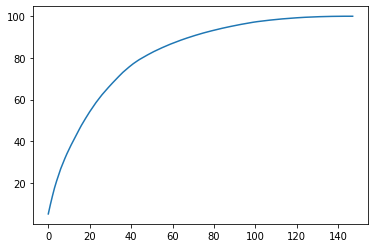

In [20]:
# Importancia acumulada.
plt.plot(np.cumsum(FeatureImportancetotal.importancia))

In [21]:
from sklearn.metrics import classification_report
y_pred_total=model_cat_total.predict(Xt_test)
print(classification_report(yt_test, y_pred_total, target_names=['NOyC','OyC']))

              precision    recall  f1-score   support

        NOyC       0.81      0.80      0.81     30906
         OyC       0.82      0.83      0.82     33421

    accuracy                           0.82     64327
   macro avg       0.82      0.82      0.82     64327
weighted avg       0.82      0.82      0.82     64327



## Features Seleccionados y modelo. 

In [76]:
# Features Seleccionados.
features=['score',
          'age',
          'nconsultas',
          'mesesBancarizacion',
          'operaYcumple',
          'score_enconsulta_min',
          'ANTIGUEDAD_LAB',
          'tiempo_interconsulta_min',
          'JUBILADO',
          'RELAC_DEP',
          'usa_score',
          'tieneObraSocial',
          'autonomo',
          'scorecard',
          'compromiso',
          'class_F',
          'class_R',
          'class_T',
          'sex_1.0',
          'cantBancos',
          'modeloAuto',
          'ingresoFilled']

In [77]:
X=df[features]
X.mesesBancarizacion.fillna(999,inplace=True)
X.score.fillna(-1,inplace=True)
y=df['OyC']


C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [78]:
X.head()

,score,age,nconsultas,mesesBancarizacion,operaYcumple,score_enconsulta_min,ANTIGUEDAD_LAB,tiempo_interconsulta_min,JUBILADO,RELAC_DEP,...,autonomo,scorecard,compromiso,class_F,class_R,class_T,sex_1.0,cantBancos,modeloAuto,ingresoFilled
0,518.0,41.0,4,32.0,2.0,-1,0.0,2,1.0,0.0,...,0.0,4.0,12.3,0,1,0,0,7.0,0.0,5.0
1,518.0,41.0,1,32.0,2.0,851,0.0,99,1.0,0.0,...,0.0,4.0,12.3,0,0,0,0,7.0,0.0,5.0
2,518.0,41.0,3,32.0,2.0,884,0.0,2,1.0,0.0,...,0.0,4.0,12.3,0,0,1,0,7.0,0.0,5.0
3,518.0,41.0,2,32.0,2.0,-1,0.0,4,1.0,0.0,...,0.0,4.0,12.3,0,0,1,0,7.0,0.0,5.0
4,518.0,41.0,1,32.0,2.0,812,0.0,99,1.0,0.0,...,0.0,4.0,12.3,0,1,0,0,7.0,0.0,5.0


In [79]:
y.value_counts()

1    166536
0    155098
Name: OyC, dtype: int64

In [80]:
X.shape

(321634, 22)

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    custom_loss=['Precision'] , #cat_features=cat_names,
    random_seed=42 
)
model_cat.fit(X_train, y_train,             
    eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.139749
0:	learn: 0.6607535	test: 0.6602719	best: 0.6602719 (0)	total: 206ms	remaining: 3m 25s
1:	learn: 0.6361909	test: 0.6354669	best: 0.6354669 (1)	total: 395ms	remaining: 3m 17s
2:	learn: 0.6193847	test: 0.6184425	best: 0.6184425 (2)	total: 569ms	remaining: 3m 8s
3:	learn: 0.6059941	test: 0.6048720	best: 0.6048720 (3)	total: 755ms	remaining: 3m 7s
4:	learn: 0.5967711	test: 0.5954007	best: 0.5954007 (4)	total: 971ms	remaining: 3m 13s
5:	learn: 0.5890247	test: 0.5876182	best: 0.5876182 (5)	total: 1.22s	remaining: 3m 22s
6:	learn: 0.5833625	test: 0.5819038	best: 0.5819038 (6)	total: 1.47s	remaining: 3m 28s
7:	learn: 0.5789721	test: 0.5774464	best: 0.5774464 (7)	total: 1.67s	remaining: 3m 27s
8:	learn: 0.5752610	test: 0.5736269	best: 0.5736269 (8)	total: 1.85s	remaining: 3m 24s
9:	learn: 0.5721029	test: 0.5704803	best: 0.5704803 (9)	total: 2.04s	remaining: 3m 21s
10:	learn: 0.5693044	test: 0.5677871	best: 0.5677871 (10)	total: 2.22s	remaining: 3m 19s
11:	learn: 0.

93:	learn: 0.5338411	test: 0.5339310	best: 0.5339310 (93)	total: 17.5s	remaining: 2m 48s
94:	learn: 0.5337039	test: 0.5338276	best: 0.5338276 (94)	total: 17.7s	remaining: 2m 48s
95:	learn: 0.5335343	test: 0.5336855	best: 0.5336855 (95)	total: 17.9s	remaining: 2m 48s
96:	learn: 0.5333424	test: 0.5335491	best: 0.5335491 (96)	total: 18s	remaining: 2m 47s
97:	learn: 0.5332072	test: 0.5334743	best: 0.5334743 (97)	total: 18.2s	remaining: 2m 47s
98:	learn: 0.5329810	test: 0.5332995	best: 0.5332995 (98)	total: 18.4s	remaining: 2m 47s
99:	learn: 0.5328097	test: 0.5331757	best: 0.5331757 (99)	total: 18.6s	remaining: 2m 46s
100:	learn: 0.5326317	test: 0.5330717	best: 0.5330717 (100)	total: 18.7s	remaining: 2m 46s
101:	learn: 0.5324379	test: 0.5328706	best: 0.5328706 (101)	total: 18.9s	remaining: 2m 46s
102:	learn: 0.5321713	test: 0.5325980	best: 0.5325980 (102)	total: 19.1s	remaining: 2m 46s
103:	learn: 0.5320555	test: 0.5324673	best: 0.5324673 (103)	total: 19.3s	remaining: 2m 45s
104:	learn: 0.5

184:	learn: 0.5222607	test: 0.5251072	best: 0.5251072 (184)	total: 33.8s	remaining: 2m 28s
185:	learn: 0.5220751	test: 0.5250189	best: 0.5250189 (185)	total: 34s	remaining: 2m 28s
186:	learn: 0.5219760	test: 0.5249573	best: 0.5249573 (186)	total: 34.2s	remaining: 2m 28s
187:	learn: 0.5219183	test: 0.5249424	best: 0.5249424 (187)	total: 34.3s	remaining: 2m 28s
188:	learn: 0.5218273	test: 0.5248842	best: 0.5248842 (188)	total: 34.5s	remaining: 2m 28s
189:	learn: 0.5217567	test: 0.5248448	best: 0.5248448 (189)	total: 34.7s	remaining: 2m 27s
190:	learn: 0.5215994	test: 0.5247152	best: 0.5247152 (190)	total: 34.9s	remaining: 2m 27s
191:	learn: 0.5214546	test: 0.5245804	best: 0.5245804 (191)	total: 35.1s	remaining: 2m 27s
192:	learn: 0.5213561	test: 0.5244933	best: 0.5244933 (192)	total: 35.2s	remaining: 2m 27s
193:	learn: 0.5212512	test: 0.5244058	best: 0.5244058 (193)	total: 35.4s	remaining: 2m 27s
194:	learn: 0.5211863	test: 0.5243566	best: 0.5243566 (194)	total: 35.6s	remaining: 2m 26s
1

276:	learn: 0.5140516	test: 0.5193843	best: 0.5193843 (276)	total: 51s	remaining: 2m 13s
277:	learn: 0.5139755	test: 0.5193270	best: 0.5193270 (277)	total: 51.2s	remaining: 2m 12s
278:	learn: 0.5139190	test: 0.5193020	best: 0.5193020 (278)	total: 51.4s	remaining: 2m 12s
279:	learn: 0.5138628	test: 0.5192619	best: 0.5192619 (279)	total: 51.6s	remaining: 2m 12s
280:	learn: 0.5137603	test: 0.5192235	best: 0.5192235 (280)	total: 51.8s	remaining: 2m 12s
281:	learn: 0.5136634	test: 0.5191598	best: 0.5191598 (281)	total: 51.9s	remaining: 2m 12s
282:	learn: 0.5135725	test: 0.5191041	best: 0.5191041 (282)	total: 52.1s	remaining: 2m 12s
283:	learn: 0.5135199	test: 0.5190631	best: 0.5190631 (283)	total: 52.3s	remaining: 2m 11s
284:	learn: 0.5134035	test: 0.5189969	best: 0.5189969 (284)	total: 52.5s	remaining: 2m 11s
285:	learn: 0.5133193	test: 0.5189119	best: 0.5189119 (285)	total: 52.7s	remaining: 2m 11s
286:	learn: 0.5132267	test: 0.5187932	best: 0.5187932 (286)	total: 52.9s	remaining: 2m 11s
2

368:	learn: 0.5067827	test: 0.5145256	best: 0.5145256 (368)	total: 1m 9s	remaining: 1m 59s
369:	learn: 0.5066837	test: 0.5144246	best: 0.5144246 (369)	total: 1m 9s	remaining: 1m 58s
370:	learn: 0.5066420	test: 0.5144003	best: 0.5144003 (370)	total: 1m 9s	remaining: 1m 58s
371:	learn: 0.5065763	test: 0.5143475	best: 0.5143475 (371)	total: 1m 10s	remaining: 1m 58s
372:	learn: 0.5064991	test: 0.5142876	best: 0.5142876 (372)	total: 1m 10s	remaining: 1m 58s
373:	learn: 0.5064667	test: 0.5142823	best: 0.5142823 (373)	total: 1m 10s	remaining: 1m 58s
374:	learn: 0.5063800	test: 0.5142596	best: 0.5142596 (374)	total: 1m 10s	remaining: 1m 58s
375:	learn: 0.5063298	test: 0.5142284	best: 0.5142284 (375)	total: 1m 10s	remaining: 1m 57s
376:	learn: 0.5062343	test: 0.5141836	best: 0.5141836 (376)	total: 1m 11s	remaining: 1m 57s
377:	learn: 0.5061472	test: 0.5141157	best: 0.5141157 (377)	total: 1m 11s	remaining: 1m 57s
378:	learn: 0.5060616	test: 0.5140578	best: 0.5140578 (378)	total: 1m 11s	remaining

458:	learn: 0.5005642	test: 0.5105977	best: 0.5105977 (458)	total: 1m 26s	remaining: 1m 41s
459:	learn: 0.5005154	test: 0.5105743	best: 0.5105743 (459)	total: 1m 26s	remaining: 1m 41s
460:	learn: 0.5004545	test: 0.5105287	best: 0.5105287 (460)	total: 1m 26s	remaining: 1m 41s
461:	learn: 0.5003660	test: 0.5104668	best: 0.5104668 (461)	total: 1m 26s	remaining: 1m 41s
462:	learn: 0.5003251	test: 0.5104650	best: 0.5104650 (462)	total: 1m 26s	remaining: 1m 40s
463:	learn: 0.5002888	test: 0.5104532	best: 0.5104532 (463)	total: 1m 27s	remaining: 1m 40s
464:	learn: 0.5002413	test: 0.5104206	best: 0.5104206 (464)	total: 1m 27s	remaining: 1m 40s
465:	learn: 0.5001889	test: 0.5103674	best: 0.5103674 (465)	total: 1m 27s	remaining: 1m 40s
466:	learn: 0.5001194	test: 0.5103213	best: 0.5103213 (466)	total: 1m 27s	remaining: 1m 40s
467:	learn: 0.5000257	test: 0.5102890	best: 0.5102890 (467)	total: 1m 27s	remaining: 1m 39s
468:	learn: 0.4999311	test: 0.5102244	best: 0.5102244 (468)	total: 1m 28s	remain

548:	learn: 0.4952599	test: 0.5073706	best: 0.5073706 (548)	total: 1m 42s	remaining: 1m 24s
549:	learn: 0.4952098	test: 0.5073220	best: 0.5073220 (549)	total: 1m 43s	remaining: 1m 24s
550:	learn: 0.4951583	test: 0.5072847	best: 0.5072847 (550)	total: 1m 43s	remaining: 1m 24s
551:	learn: 0.4950976	test: 0.5072509	best: 0.5072509 (551)	total: 1m 43s	remaining: 1m 23s
552:	learn: 0.4950253	test: 0.5071862	best: 0.5071862 (552)	total: 1m 43s	remaining: 1m 23s
553:	learn: 0.4949821	test: 0.5071690	best: 0.5071690 (553)	total: 1m 43s	remaining: 1m 23s
554:	learn: 0.4949426	test: 0.5071470	best: 0.5071470 (554)	total: 1m 44s	remaining: 1m 23s
555:	learn: 0.4948952	test: 0.5071328	best: 0.5071328 (555)	total: 1m 44s	remaining: 1m 23s
556:	learn: 0.4948218	test: 0.5071146	best: 0.5071146 (556)	total: 1m 44s	remaining: 1m 23s
557:	learn: 0.4947566	test: 0.5070681	best: 0.5070681 (557)	total: 1m 44s	remaining: 1m 22s
558:	learn: 0.4947046	test: 0.5070380	best: 0.5070380 (558)	total: 1m 44s	remain

638:	learn: 0.4902384	test: 0.5045221	best: 0.5045221 (638)	total: 1m 59s	remaining: 1m 7s
639:	learn: 0.4902035	test: 0.5045110	best: 0.5045110 (639)	total: 1m 59s	remaining: 1m 7s
640:	learn: 0.4901431	test: 0.5044361	best: 0.5044361 (640)	total: 1m 59s	remaining: 1m 7s
641:	learn: 0.4901075	test: 0.5044371	best: 0.5044361 (640)	total: 1m 59s	remaining: 1m 6s
642:	learn: 0.4900283	test: 0.5043888	best: 0.5043888 (642)	total: 2m	remaining: 1m 6s
643:	learn: 0.4899412	test: 0.5043269	best: 0.5043269 (643)	total: 2m	remaining: 1m 6s
644:	learn: 0.4898954	test: 0.5043112	best: 0.5043112 (644)	total: 2m	remaining: 1m 6s
645:	learn: 0.4898294	test: 0.5042810	best: 0.5042810 (645)	total: 2m	remaining: 1m 6s
646:	learn: 0.4897780	test: 0.5042565	best: 0.5042565 (646)	total: 2m	remaining: 1m 5s
647:	learn: 0.4897273	test: 0.5042100	best: 0.5042100 (647)	total: 2m	remaining: 1m 5s
648:	learn: 0.4896629	test: 0.5041496	best: 0.5041496 (648)	total: 2m 1s	remaining: 1m 5s
649:	learn: 0.4895921	te

730:	learn: 0.4850944	test: 0.5012048	best: 0.5012048 (730)	total: 2m 16s	remaining: 50.2s
731:	learn: 0.4850541	test: 0.5011827	best: 0.5011827 (731)	total: 2m 16s	remaining: 50s
732:	learn: 0.4849987	test: 0.5011635	best: 0.5011635 (732)	total: 2m 16s	remaining: 49.8s
733:	learn: 0.4849234	test: 0.5010904	best: 0.5010904 (733)	total: 2m 16s	remaining: 49.6s
734:	learn: 0.4848912	test: 0.5010878	best: 0.5010878 (734)	total: 2m 17s	remaining: 49.4s
735:	learn: 0.4848346	test: 0.5010287	best: 0.5010287 (735)	total: 2m 17s	remaining: 49.2s
736:	learn: 0.4847727	test: 0.5010045	best: 0.5010045 (736)	total: 2m 17s	remaining: 49s
737:	learn: 0.4847218	test: 0.5009784	best: 0.5009784 (737)	total: 2m 17s	remaining: 48.9s
738:	learn: 0.4846503	test: 0.5009188	best: 0.5009188 (738)	total: 2m 17s	remaining: 48.7s
739:	learn: 0.4846111	test: 0.5009057	best: 0.5009057 (739)	total: 2m 17s	remaining: 48.5s
740:	learn: 0.4845380	test: 0.5008472	best: 0.5008472 (740)	total: 2m 18s	remaining: 48.3s
741

822:	learn: 0.4806169	test: 0.4987179	best: 0.4987179 (822)	total: 2m 33s	remaining: 33s
823:	learn: 0.4805838	test: 0.4986966	best: 0.4986966 (823)	total: 2m 33s	remaining: 32.8s
824:	learn: 0.4805443	test: 0.4986961	best: 0.4986961 (824)	total: 2m 33s	remaining: 32.6s
825:	learn: 0.4805157	test: 0.4987094	best: 0.4986961 (824)	total: 2m 33s	remaining: 32.4s
826:	learn: 0.4804467	test: 0.4986794	best: 0.4986794 (826)	total: 2m 34s	remaining: 32.2s
827:	learn: 0.4804081	test: 0.4986541	best: 0.4986541 (827)	total: 2m 34s	remaining: 32s
828:	learn: 0.4803498	test: 0.4986252	best: 0.4986252 (828)	total: 2m 34s	remaining: 31.8s
829:	learn: 0.4803023	test: 0.4986075	best: 0.4986075 (829)	total: 2m 34s	remaining: 31.7s
830:	learn: 0.4801921	test: 0.4985017	best: 0.4985017 (830)	total: 2m 34s	remaining: 31.5s
831:	learn: 0.4801288	test: 0.4984506	best: 0.4984506 (831)	total: 2m 34s	remaining: 31.3s
832:	learn: 0.4800626	test: 0.4983987	best: 0.4983987 (832)	total: 2m 35s	remaining: 31.1s
833

913:	learn: 0.4760303	test: 0.4960256	best: 0.4960256 (913)	total: 2m 50s	remaining: 16s
914:	learn: 0.4760009	test: 0.4960271	best: 0.4960256 (913)	total: 2m 50s	remaining: 15.8s
915:	learn: 0.4759726	test: 0.4960331	best: 0.4960256 (913)	total: 2m 50s	remaining: 15.6s
916:	learn: 0.4759411	test: 0.4960187	best: 0.4960187 (916)	total: 2m 50s	remaining: 15.4s
917:	learn: 0.4759083	test: 0.4960012	best: 0.4960012 (917)	total: 2m 50s	remaining: 15.3s
918:	learn: 0.4758410	test: 0.4959709	best: 0.4959709 (918)	total: 2m 50s	remaining: 15.1s
919:	learn: 0.4757934	test: 0.4959337	best: 0.4959337 (919)	total: 2m 51s	remaining: 14.9s
920:	learn: 0.4757298	test: 0.4958746	best: 0.4958746 (920)	total: 2m 51s	remaining: 14.7s
921:	learn: 0.4756648	test: 0.4958243	best: 0.4958243 (921)	total: 2m 51s	remaining: 14.5s
922:	learn: 0.4756154	test: 0.4957825	best: 0.4957825 (922)	total: 2m 51s	remaining: 14.3s
923:	learn: 0.4755646	test: 0.4957375	best: 0.4957375 (923)	total: 2m 51s	remaining: 14.1s
9

In [83]:
atributos = X_train.columns
# Calcular la importancia de los atributos
FeatureImportance=pd.DataFrame({'Atributo':atributos,
              'importancia':model_cat.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).reset_index()

In [84]:
FeatureImportance

,index,Atributo,importancia
0,14,compromiso,15.901771
1,0,score,13.465932
2,3,mesesBancarizacion,10.006719
3,19,cantBancos,8.749605
4,1,age,8.590067
5,4,operaYcumple,7.646504
6,21,ingresoFilled,7.287038
7,13,scorecard,5.308197
8,6,ANTIGUEDAD_LAB,4.407904
9,20,modeloAuto,3.139403


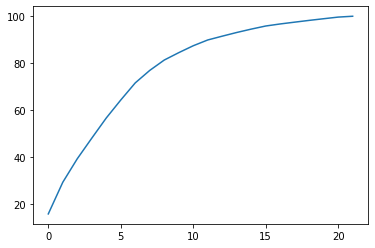

In [85]:
# Importancia acumulada.
plt.plot(np.cumsum(FeatureImportance.importancia))

In [86]:
from sklearn.metrics import classification_report
y_pred_dtc=model_cat.predict(X_test)
print(classification_report(y_test, y_pred_dtc, target_names=['NOyC','OyC']))

              precision    recall  f1-score   support

        NOyC       0.77      0.70      0.74     30906
         OyC       0.75      0.81      0.78     33421

    accuracy                           0.76     64327
   macro avg       0.76      0.76      0.76     64327
weighted avg       0.76      0.76      0.76     64327



In [87]:
X.isnull().sum()

score                       0
age                         0
nconsultas                  0
mesesBancarizacion          0
operaYcumple                0
score_enconsulta_min        0
ANTIGUEDAD_LAB              0
tiempo_interconsulta_min    0
JUBILADO                    0
RELAC_DEP                   0
usa_score                   0
tieneObraSocial             0
autonomo                    0
scorecard                   0
compromiso                  0
class_F                     0
class_R                     0
class_T                     0
sex_1.0                     0
cantBancos                  0
modeloAuto                  0
ingresoFilled               0
dtype: int64

# Redes Neuronales

In [88]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [108]:
import pickle

with open('variables.pickle', 'wb') as handle:
    pickle.dump([scaler,X_train,X_test,y_train,y_test,X_train_std,X_test_std],handle)

In [95]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.metrics import precision
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
# load the dataset
model = Sequential()
model.add(Dense(500, input_dim=22, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(75, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[precision_m, auroc, 'accuracy'])

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 500)               11500     
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               50200     
_________________________________________________________________
dense_12 (Dense)             (None, 125)               25125     
_________________________________________________________________
dense_13 (Dense)             (None, 75)                9450      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
__________

In [97]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='model_small2-{epoch:02d}-{val_precision_m:.2f}.hdf5',save_best_only=True, monitor='val_precision_m', mode='max', verbose=1) 
model.fit(X_train_std, y_train,validation_data=(X_test_std, y_test),batch_size=128, epochs=100, verbose=1, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 257307 samples, validate on 64327 samples
Epoch 1/100
257307/257307 [==============================] - 25s 98us/step - loss: 0.5624 - precision_m: 0.6950 - auroc: 0.7790 - acc: 0.7079 - val_loss: 0.5564 - val_precision_m: 0.7196 - val_auroc: 0.7894 - val_acc: 0.7130

Epoch 00001: val_precision_m improved from -inf to 0.71959, saving model to model_small2-01-0.72.hdf5
Epoch 2/100
257307/257307 [==============================] - 23s 90us/step - loss: 0.5491 - precision_m: 0.7050 - auroc: 0.7912 - acc: 0.7176 - val_loss: 0.5438 - val_precision_m: 0.7025 - val_auroc: 0.7945 - val_acc: 0.7206

Epoch 00002: val_precision_m did not improve from 0.71959
Epoch 3/100
257307/257307 [==============================] - 23s 88us/step - loss: 0.5441 - precision_m: 0.7081 - auroc: 0.7957 - acc: 0.7207 - val_loss: 0.5407 - val_precision_m: 0.7032 - val_auroc: 0.7975 - val_acc: 0.7203

Epoch 00003: val_precision_m did not improve from 0.71959
Epoch


Epoch 00027: val_precision_m did not improve from 0.74753
Epoch 28/100
257307/257307 [==============================] - 26s 101us/step - loss: 0.4091 - precision_m: 0.8032 - auroc: 0.8927 - acc: 0.8058 - val_loss: 0.5407 - val_precision_m: 0.7518 - val_auroc: 0.8243 - val_acc: 0.7471

Epoch 00028: val_precision_m improved from 0.74753 to 0.75184, saving model to model_small2-28-0.75.hdf5
Epoch 29/100
257307/257307 [==============================] - 27s 104us/step - loss: 0.4042 - precision_m: 0.8051 - auroc: 0.8955 - acc: 0.8087 - val_loss: 0.5483 - val_precision_m: 0.7453 - val_auroc: 0.8234 - val_acc: 0.7467

Epoch 00029: val_precision_m did not improve from 0.75184
Epoch 30/100
257307/257307 [==============================] - 27s 104us/step - loss: 0.3992 - precision_m: 0.8079 - auroc: 0.8984 - acc: 0.8108 - val_loss: 0.5432 - val_precision_m: 0.7520 - val_auroc: 0.8297 - val_acc: 0.7527

Epoch 00030: val_precision_m improved from 0.75184 to 0.75199, saving model to model_small2-30


Epoch 00055: val_precision_m did not improve from 0.76696
Epoch 56/100
257307/257307 [==============================] - 23s 89us/step - loss: 0.3049 - precision_m: 0.8637 - auroc: 0.9422 - acc: 0.8608 - val_loss: 0.6604 - val_precision_m: 0.7705 - val_auroc: 0.8306 - val_acc: 0.7603

Epoch 00056: val_precision_m improved from 0.76696 to 0.77050, saving model to model_small2-56-0.77.hdf5
Epoch 57/100
257307/257307 [==============================] - 23s 90us/step - loss: 0.3017 - precision_m: 0.8655 - auroc: 0.9431 - acc: 0.8617 - val_loss: 0.6649 - val_precision_m: 0.7678 - val_auroc: 0.8295 - val_acc: 0.7569

Epoch 00057: val_precision_m did not improve from 0.77050
Epoch 58/100
257307/257307 [==============================] - 23s 89us/step - loss: 0.3007 - precision_m: 0.8678 - auroc: 0.9436 - acc: 0.8628 - val_loss: 0.6813 - val_precision_m: 0.7666 - val_auroc: 0.8293 - val_acc: 0.7559

Epoch 00058: val_precision_m did not improve from 0.77050
Epoch 59/100
257307/257307 [===========

257307/257307 [==============================] - 22s 85us/step - loss: 0.2507 - precision_m: 0.8944 - auroc: 0.9612 - acc: 0.8878 - val_loss: 0.7739 - val_precision_m: 0.7645 - val_auroc: 0.8271 - val_acc: 0.7587

Epoch 00084: val_precision_m did not improve from 0.77431
Epoch 85/100
257307/257307 [==============================] - 23s 88us/step - loss: 0.2495 - precision_m: 0.8940 - auroc: 0.9616 - acc: 0.8878 - val_loss: 0.8140 - val_precision_m: 0.7697 - val_auroc: 0.8261 - val_acc: 0.7584

Epoch 00085: val_precision_m did not improve from 0.77431
Epoch 86/100
257307/257307 [==============================] - 23s 91us/step - loss: 0.2484 - precision_m: 0.8967 - auroc: 0.9619 - acc: 0.8891 - val_loss: 0.8158 - val_precision_m: 0.7659 - val_auroc: 0.8256 - val_acc: 0.7584

Epoch 00086: val_precision_m did not improve from 0.77431
Epoch 87/100
257307/257307 [==============================] - 24s 93us/step - loss: 0.2464 - precision_m: 0.8972 - auroc: 0.9625 - acc: 0.8903 - val_loss: 0.7

In [98]:
model.predict(X_test_std[0].reshape(1,-1))

array([[1.]], dtype=float32)